# **NOTED**

In this part, we will learn cats and dogs classification from The Asirra dataset. The library that we used, there are:
1. Pandas: For reading/writing data
2. Matplotlib: For displaying images
3. Tensorflow keras models: For predicting
4. Tensorflow keras layers: For layering Neural Network and CNN

In [1]:
# generate dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 43.0MB/s]
 98% 266M/271M [00:01<00:00, 179MB/s]
100% 271M/271M [00:01<00:00, 168MB/s]
 99% 540M/544M [00:03<00:00, 157MB/s]
100% 544M/544M [00:03<00:00, 158MB/s]


In [ ]:
# unzipping data
!unzip "train.zip"
!unzip "test.zip"

In [3]:
# import the libraries
import os
from os import getcwd, listdir

import zipfile
import random
import shutil
from shutil import copyfile
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

In [4]:
# directory dataset
DIR_TRAIN = "/content/train"
DIR_TEST = "/content/test"

In [ ]:
# checking data format
train_imgs = os.listdir(DIR_TRAIN)
test_imgs = os.listdir(DIR_TEST)

print(train_imgs[:5])
print(test_imgs[:5])

In [6]:
# counting dataset
dogs_list = [img for img in train_imgs if img.split(".")[0] == 'dog']
cats_list = [img for img in train_imgs if img.split(".")[0] == 'cat']

print("Count of Dogs Images: ",len(dogs_list))
print("Count of Cats Images: ",len(cats_list))

Count of Dogs Images:  12500
Count of Cats Images:  12500


In [7]:
categories = []
for file_name in train_imgs:
  category = file_name.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({'filename':train_imgs,
                   'category':categories})
df.head()

,filename,category
0,dog.8755.jpg,1
1,dog.11554.jpg,1
2,cat.4593.jpg,0
3,dog.10227.jpg,1
4,dog.9212.jpg,1


In [8]:
df['category'] = df.category.replace({0:'cat',1:'dog'})

# splitting dataset
train_data, test_data = train_test_split(df, test_size=0.2, 
                                         random_state=42)
train_data, test_data = train_data.reset_index(drop=True), test_data.reset_index(drop=True)

total_train = train_data.shape[0]
total_test = test_data.shape[0]

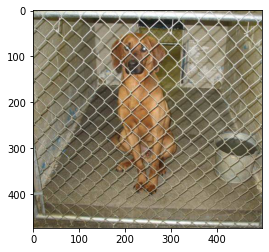

In [9]:
# Visualize sample random images
sample = random.choice(train_imgs)
image = load_img("train/"+sample)
plt.imshow(image);

In [10]:
# Transform for image - augmentations
# image_size = (image_width, image_height)
image_size = (128, 128)
batch_size = 15

train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(train_data, 
                                                    "train/",
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=image_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_dataframe(test_data, 
                                                        "train/", 
                                                        x_col='filename',
                                                        y_col='category',
                                                        target_size=image_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [11]:
# Generator work
example_data = train_data.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(example_data,
                                                      "train/",
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=image_size,
                                                      class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


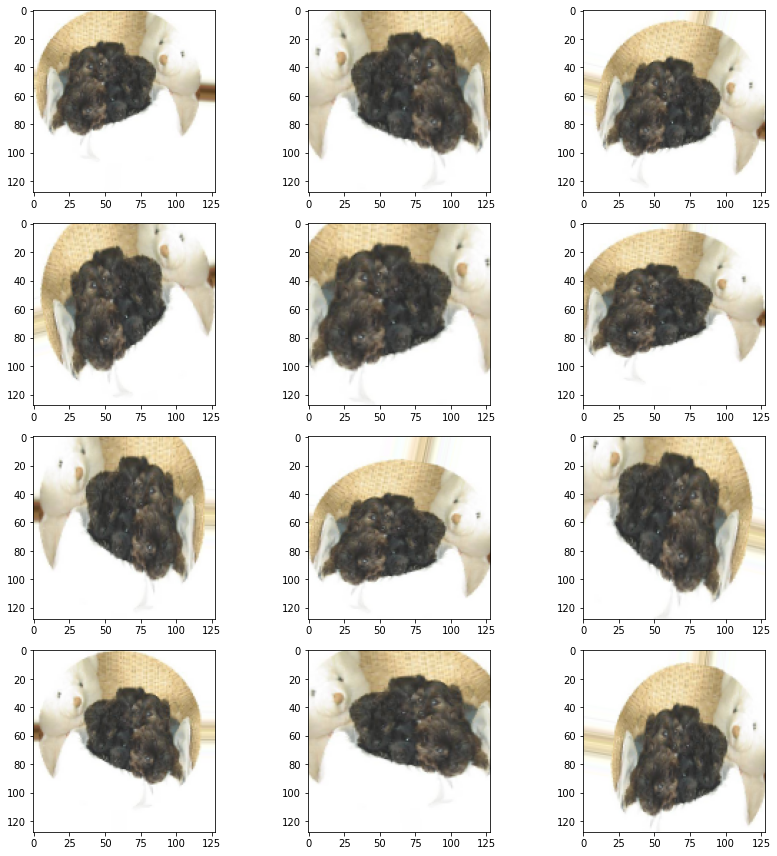

In [12]:
# Showing a sample generator work
plt.figure(figsize=(12,12))
for i in range(0, 12):
  plt.subplot(4, 3, i+1)
  for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

In [13]:
# Build a model

# KET:
# 3 Layer (Extraction) + 1 Classifier
# LAYER 1, 2, 3: Conv, BatchNorm, Pooling, DropOut
# Classifier: Flatten, Dense, DropOut, Dense
image_width = 128
image_height = 128
image_channels = 3

model = Sequential()

# LAYER 1
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=(image_width, 
                              image_height, 
                              image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# LAYER 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# LAYER 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CLASSIFIER
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'rmsprop', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [ ]:
# FIT MODEL
epochs = 10
history = model.fit_generator(
    train_generator, epochs = epochs,
    validation_data = testing_generator,
    validation_steps = total_test//batch_size,
    steps_per_epoch = total_train//batch_size
)

Epoch 1/10
1333/1333 [==============================] - 1168s 874ms/step - loss: 0.7330 - accuracy: 0.6385 - val_loss: 0.5784 - val_accuracy: 0.7201
Epoch 2/10
1333/1333 [==============================] - 1170s 878ms/step - loss: 0.5527 - accuracy: 0.7248 - val_loss: 0.5610 - val_accuracy: 0.7441
Epoch 3/10
1333/1333 [==============================] - 1158s 869ms/step - loss: 0.4953 - accuracy: 0.7693 - val_loss: 0.5152 - val_accuracy: 0.7437
Epoch 4/10
1007/1333 [=====================>........] - ETA: 4:28 - loss: 0.4647 - accuracy: 0.7862

In [ ]:
# VIRTUALIZE TRAINING
